In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import LabelEncoder

/Users/kawaii/miniconda3/envs/m1_no_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def create_circular_template(diameter, shape, full_circle=True):
    template = np.zeros(shape, dtype=np.uint8)
    center = (shape[1] // 2, shape[0] // 2)  # Center of the template
    radius = diameter // 2

    if full_circle:
        cv2.circle(template, center, radius, 255, -1)
    else:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.circle(mask, center, radius, 255, -1)
        template[shape[0]//2:, :] = mask[shape[0]//2:, :]

    return template

In [4]:
def create_templates():
    template_shapes = [
        (256, 256),  # Small circular template
        (384, 384),  # Larger circular template
        (256, 512),  # Small semi-circular (horizontal) template
        (384, 768)   # Larger semi-circular (horizontal) template
    ]

    templates = []
    for shape in template_shapes:
        templates.append(create_circular_template(diameter=min(shape), shape=shape, full_circle=True))
        templates.append(create_circular_template(diameter=min(shape), shape=shape, full_circle=False))
    
    return templates

templates = create_templates()

In [5]:
def extract_best_match_roi(image, templates):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    L_channel = lab_image[:, :, 0]  # Extract the L channel

    best_match = None
    best_value = -1
    best_location = None

    # Perform cross-correlation with each template
    for template in templates:
        result = cv2.matchTemplate(L_channel, template, cv2.TM_CCORR_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        if max_val > best_value:
            best_value = max_val
            best_match = template
            best_location = max_loc

    if best_match is not None:
        x, y = best_location
        h, w = best_match.shape[:2]
        roi = image[y:y+h, x:x+w]  # Crop the ROI from the original image
        return roi
    else:
        return None

In [9]:
import cv2
import os


output_dir = 'extracted_rois'
os.makedirs(output_dir, exist_ok=True)

# Define target size for VGG model (224x224)
target_size = (224, 224)

# Function to extract and save ROIs with the original filename
def save_roi_image_with_original_name(image, templates, original_filename, label):
    roi = extract_best_match_roi(image, templates)

    if roi is not None:
        roi_resized = cv2.resize(roi, target_size)
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        filename = os.path.splitext(original_filename)[0]
        filename = f"{filename}_roi.bmp"
        filepath = os.path.join(label_dir, filename)

        cv2.imwrite(filepath, roi_resized)



image_directory = 'I1'
label = ''

for image_filename in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_filename)
    image = cv2.imread(image_path)

    if image is not None:
        save_roi_image_with_original_name(image, templates, image_filename, label)

print(f"All ROIs processed and saved in {output_dir}")

All ROIs processed and saved in extracted_rois


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Add this import
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

In [7]:
image_dir = 'extracted_rois'
IMG_SIZE = (224, 224)

In [12]:
def load_and_preprocess_data(image_dir, img_size):
    images = []
    labels = []

    print("Loading images from:", image_dir)

    for filename in os.listdir(image_dir):
        if filename.endswith((".bmp", ".BMP")):
            # Load image
            img_path = os.path.join(image_dir, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Failed to load image: {filename}")
                continue

            # Resize image
            image_resized = cv2.resize(image, img_size)

            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

            # Append image and label
            images.append(image_rgb)
            label = filename.split('_')[0]  # Extract label (e.g., 'FL')
            labels.append(label)

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)

    # Preprocess images for VGG16
    images = preprocess_input(images)

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_one_hot = to_categorical(labels_encoded)

    print(f'\nLoaded {len(images)} images with shape: {images.shape}')
    print("Classes:", label_encoder.classes_)
    print("Number of classes:", len(label_encoder.classes_))

    return images, labels_one_hot, label_encoder

In [13]:
images, labels_one_hot, label_encoder = load_and_preprocess_data(image_dir, IMG_SIZE)

Loading images from: extracted_rois

Loaded 105 images with shape: (105, 224, 224, 3)
Classes: ['CO' 'FL' 'MA' 'MC']
Number of classes: 4


In [9]:
import pickle

def save_label_encoder(label_encoder, filename='label_encoder.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(label_encoder, f)


save_label_encoder(label_encoder)

NameError: name 'label_encoder' is not defined

In [15]:
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    # Create the base pre-trained model
    base_model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create new model
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [16]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=labels_one_hot  # This ensures balanced split
)

In [17]:
model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=len(label_encoder.classes_))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=9,
    batch_size=32,
    verbose=1
)

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f'\nValidation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Epoch 1/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2699 - loss: 5.8669 - val_accuracy: 0.2381 - val_loss: 3.6373
Epoch 2/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5162 - loss: 2.6513 - val_accuracy: 0.5238 - val_loss: 1.6769
Epoch 3/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7794 - loss: 1.1394 - val_accuracy: 0.3810 - val_loss: 1.8314
Epoch 4/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.7109 - loss: 1.1087 - val_accuracy: 0.6190 - val_loss: 1.1415
Epoch 5/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9092 - loss: 0.2672 - val_accuracy: 0.6667 - val_loss: 1.0962
Epoch 6/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9016 - loss: 0.4100 - val_accuracy: 0.6190 - val_loss: 0.9538
Epoch 7/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9684 - loss: 0.1465 - val_accuracy: 0.7143 - val_loss: 0.8373
Epoch 8/9
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9626 - loss: 0.1888 - val_accuracy: 0.7143 - val_loss: 0.9412
Epoch 9/9
3/3 ━━━

In [19]:
model.save('tear_film_model.keras')

# Load saved model

In [10]:
def load_label_encoder(filename='label_encoder.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [11]:
saved_model = tf.keras.models.load_model('tear_film_model.keras')
saved_label_encoder = load_label_encoder()

In [12]:
def get_model_predictions(images):
    processed_images = preprocess_input(images.copy())
    return saved_model.predict(processed_images)

In [13]:
def extract_best_match_roi(image, templates):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    L_channel = lab_image[:, :, 0]

    best_match = None
    best_value = -1
    best_location = None
    best_template = None

    # Perform cross-correlation for each template
    for template in templates:
        # Perform template matching on the L channel
        result = cv2.matchTemplate(L_channel, template, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Update best match if current match is better
        if max_val > best_value:
            best_value = max_val
            best_template = template
            best_location = max_loc

    if best_template is not None:
        x, y = best_location
        h, w = best_template.shape[:2]
        roi = image[y:y+h, x:x+w]  # Extract ROI from original BGR image
        return roi, (x, y, w, h)
    else:
        return None, None

In [14]:
def explain_prediction_with_roi(image_path, templates, label_encoder_path='label_encoder.pkl', num_samples=150):
    # Load the label encoder
    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)
    
    # Load original image
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Failed to load image: {image_path}")
        return
    
    roi, roi_coords = extract_best_match_roi(original_image, templates)
    if roi is None:
        print(f"Failed to extract ROI from image: {image_path}")
        return
    
    roi_resized = cv2.resize(roi, (224, 224))
    roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
    explainer = lime_image.LimeImageExplainer()
    
    explanation = explainer.explain_instance(
        roi_rgb, 
        get_model_predictions,
        top_labels=5,  # Number of classes
        hide_color=0,
        num_samples=num_samples
    )
    
    # Get model prediction
    pred = get_model_predictions(np.expand_dims(roi_rgb, axis=0))
    predicted_idx = pred.argmax()
    predicted_class = label_encoder.inverse_transform([predicted_idx])[0]
    prediction_prob = pred.max() * 100
    
    # Get actual class from filename
    actual_class = image_path.split('_')[0]
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Original image with ROI highlighted
    plt.subplot(141)
    original_with_roi = original_image.copy()
    x, y, w, h = roi_coords
    cv2.rectangle(original_with_roi, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(original_with_roi, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with ROI')
    plt.axis('off')
    
    # Extracted ROI
    plt.subplot(142)
    plt.imshow(roi_rgb)
    plt.title(f'Extracted ROI\nPredicted: {predicted_class}\nActual: {actual_class}\nConfidence: {prediction_prob:.2f}%')
    plt.axis('off')
    
    # LIME explanations
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    plt.subplot(143)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Positive Influences')
    plt.axis('off')
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    plt.subplot(144)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('All Influences')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction details
    print(f"\nAnalysis for {os.path.basename(image_path)}:")
    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {prediction_prob:.2f}%")
    print("\nFeature importance:")
    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    for segment, importance in sorted(dict_heatmap.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"Segment {segment}: {'Positive' if importance > 0 else 'Negative'} influence ({importance:.3f})")

In [15]:
def process_directory(input_dir):
    """Process all images in a directory"""
    # Create templates
    templates = create_templates()
    if not templates:
        print("Failed to create templates!")
        return
    
    # Process each image
    for filename in os.listdir(input_dir):
        if filename.endswith(('.bmp', '.BMP')):
            image_path = os.path.join(input_dir, filename)
            print(f"\nProcessing: {filename}")
            explain_prediction_with_roi(image_path, templates)

  0%|                                                                                                                                               | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|████████▉                                                                                                                             | 10/150 [00:01<00:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 13%|█████████████████▊                                                                                                                    | 20/150 [00:02<00:14,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██████████████████████████▊                                                                                                           | 30/150 [00:03<00:12,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|███████████████████████████████████▋                                                                                                  | 40/150 [00:04<00:11,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|████████████████████████████████████████████▋                                                                                         | 50/150 [00:05<00:10,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|█████████████████████████████████████████████████████▌                                                                                | 60/150 [00:06<00:11,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 70/150 [00:07<00:09,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 80/150 [00:09<00:07,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90/150 [00:09<00:06,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 100/150 [00:11<00:05,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 110/150 [00:12<00:04,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 120/150 [00:13<00:03,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 130/150 [00:14<00:02,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 140/150 [00:15<00:01,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.18it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..137.0].


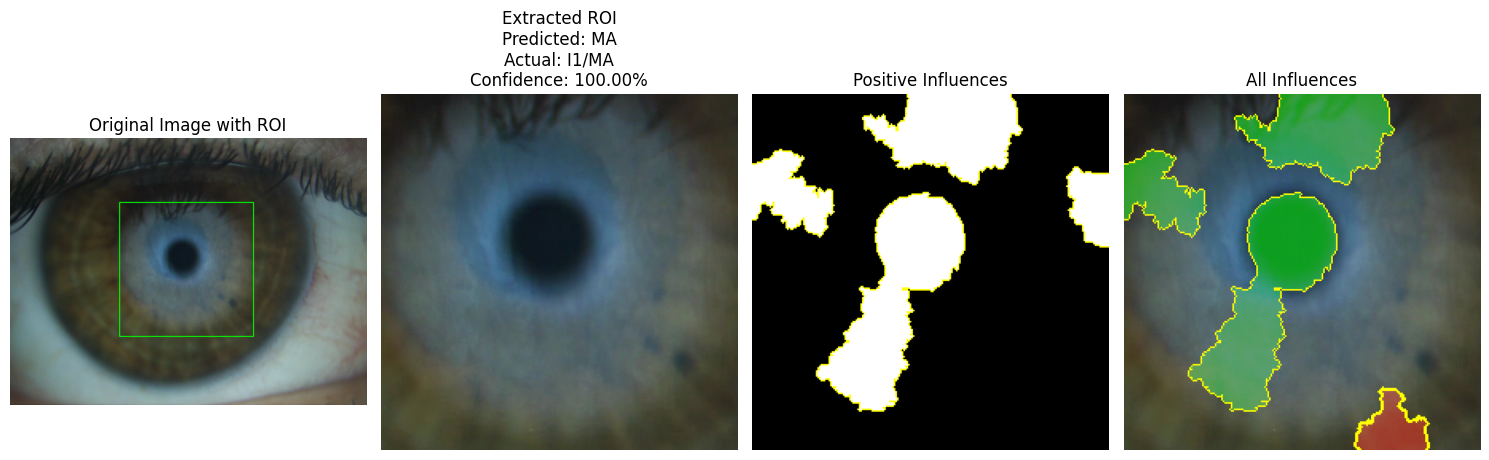


Analysis for MA_008_A2_I1_V2_02.BMP:
Actual Class: I1/MA
Predicted Class: MA
Confidence: 100.00%

Feature importance:
Segment 16: Positive influence (0.168)
Segment 34: Negative influence (-0.094)
Segment 11: Positive influence (0.087)
Segment 4: Positive influence (0.081)
Segment 26: Positive influence (0.075)


In [16]:
image_path = 'I1/MA_008_A2_I1_V2_02.BMP'
templates = create_templates()
explain_prediction_with_roi(image_path, templates)